In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [1]:
import re
import numpy as np
import tensorflow as tf
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow. keras.layers import Activation
from tensorflow.keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    # img = np.frombuffer(buffer, dtype='u1')
    # img2 = np.reshape(img,(-1, 2))
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [3]:
image = Image.open('../input/att-database-of-faces/s1/1.pgm')
img = np.array(image)
print(img.shape)

(112, 92)


In [4]:
img = read_image('../input/att-database-of-faces/s1/1.pgm')
img.shape

(112, 92)

In [5]:
size = 2
total_sample_size = 10000
PATH = '../input/att-database-of-faces/s'

def get_data(size, total_sample_size):
    #read the image
    image = read_image(PATH + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image(PATH + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image(PATH + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image(PATH + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image(PATH + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [6]:
X, Y = get_data(size, total_sample_size)

In [7]:
X.shape

(20000, 2, 1, 56, 46)

In [8]:
Y.shape

(20000, 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [10]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          padding='valid', data_format="channels_first"))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, padding='valid', data_format="channels_first"))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first")) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [11]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [12]:
input_dim

(1, 56, 46)

In [13]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [14]:
epochs = 100
rms = RMSprop()
#left_input = Input(input_dim)
#right_input = Input(input_dim)
model = Model([img_a, img_b],distance)
#plot_model(model, to_file='model.png')

In [28]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer='adam',  metrics=['acc'])

In [29]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

history = model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, nb_epoch=epochs)

Train on 11250 samples, validate on 3750 samples
Epoch 1/100
11250/11250 - 2s - loss: 0.1134 - acc: 0.1444 - val_loss: 0.1124 - val_acc: 0.1557
Epoch 2/100
11250/11250 - 1s - loss: 0.1115 - acc: 0.1426 - val_loss: 0.0971 - val_acc: 0.1291
Epoch 3/100
11250/11250 - 1s - loss: 0.1113 - acc: 0.1401 - val_loss: 0.1011 - val_acc: 0.1328
Epoch 4/100
11250/11250 - 1s - loss: 0.1092 - acc: 0.1390 - val_loss: 0.0974 - val_acc: 0.1304
Epoch 5/100
11250/11250 - 1s - loss: 0.1109 - acc: 0.1395 - val_loss: 0.0964 - val_acc: 0.1272
Epoch 6/100
11250/11250 - 1s - loss: 0.1080 - acc: 0.1344 - val_loss: 0.1078 - val_acc: 0.1493
Epoch 7/100
11250/11250 - 1s - loss: 0.1103 - acc: 0.1388 - val_loss: 0.0900 - val_acc: 0.1171
Epoch 8/100
11250/11250 - 1s - loss: 0.1095 - acc: 0.1389 - val_loss: 0.1062 - val_acc: 0.1485
Epoch 9/100
11250/11250 - 1s - loss: 0.1089 - acc: 0.1377 - val_loss: 0.0924 - val_acc: 0.1224
Epoch 10/100
11250/11250 - 1s - loss: 0.1095 - acc: 0.1372 - val_loss: 0.0982 - val_acc: 0.1301


Epoch 86/100
11250/11250 - 1s - loss: 0.0998 - acc: 0.1238 - val_loss: 0.0856 - val_acc: 0.1123
Epoch 87/100
11250/11250 - 1s - loss: 0.0994 - acc: 0.1257 - val_loss: 0.0894 - val_acc: 0.1157
Epoch 88/100
11250/11250 - 1s - loss: 0.0997 - acc: 0.1263 - val_loss: 0.0841 - val_acc: 0.1112
Epoch 89/100
11250/11250 - 1s - loss: 0.1012 - acc: 0.1267 - val_loss: 0.0922 - val_acc: 0.1109
Epoch 90/100
11250/11250 - 1s - loss: 0.0998 - acc: 0.1266 - val_loss: 0.0921 - val_acc: 0.1189
Epoch 91/100
11250/11250 - 1s - loss: 0.1001 - acc: 0.1244 - val_loss: 0.0847 - val_acc: 0.1123
Epoch 92/100
11250/11250 - 1s - loss: 0.1014 - acc: 0.1261 - val_loss: 0.0905 - val_acc: 0.1165
Epoch 93/100
11250/11250 - 1s - loss: 0.0996 - acc: 0.1217 - val_loss: 0.0911 - val_acc: 0.1195
Epoch 94/100
11250/11250 - 1s - loss: 0.1014 - acc: 0.1265 - val_loss: 0.0931 - val_acc: 0.1187
Epoch 95/100
11250/11250 - 1s - loss: 0.0999 - acc: 0.1254 - val_loss: 0.0855 - val_acc: 0.1141
Epoch 96/100
11250/11250 - 1s - loss: 0.

In [30]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [31]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean() 

In [32]:
compute_accuracy(pred, y_test)

0.8285007072135785

In [33]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


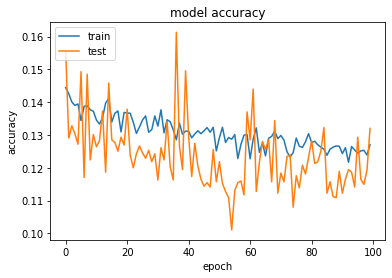

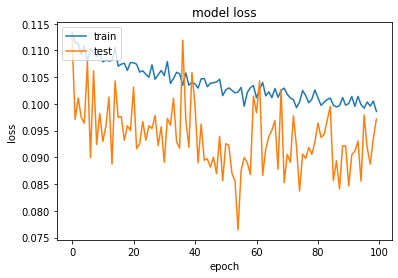

In [34]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 56, 46)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1, 56, 46)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 50)           10046       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [ ]:
model.save_weights("../input/model_90.h5")
print("Saved model to disk")